## Regression on Quandl Data from turingfinance.com


This tutorial covers regression analysis using the Python StatsModels package with Quandl integration. For motivational purposes, here is what we are working towards: a regression analysis program which receives multiple data-set names from Quandl.com, automatically downloads the data, analyses it, and plots the results in a new window. Full discussion at [turingfinance.com](http://www.turingfinance.com/regression-analysis-using-python-statsmodels-and-quandl/)

In [1]:
__author__ = 'Stuart Gordon Reid'
# code revised December 2017

import os as os
import csv as csv
import numpy as np
import scipy as spy
import sklearn as kit
import pandas as pandas
import statsmodels.api as sm
import matplotlib.pyplot as plot
from quandl import get
import quandl as quandl
from statsmodels.sandbox.regression.predstd import wls_prediction_std
# you may need to run "conda install quandl" in the terminal

### Quandl Integration  

A recurring challenge with any quantitative analysis is the availability of good quality data. Luckily for us, Quandl.com has taken on the data challenge and indexed millions of economics, financial, societal, and country specific datasets. That data is also available through a free API (Application Programming Interface) supported by the Quandl Python package.

The Quandl.get() function also supports a number of data transformations and manipulations which allow you to specify how you would like the data to be returned, including,  

order:String - ("asc"|"desc")  
rows:int - the amount of historical data to extract  
frequency:String - ("daily"|weekly"|"monthly"|"quarterly"|"annual")  
transformation:String - ("diff"|"rdiff"|"normalize"|"cumul")  
returns:String - ("numpy"|)  
Here is an example of a detailed API call using multiple data transformations,  

Minimal Quandl Download Example:  
import Quandl  
data_set = Quandl.get("WIKI/AAPL", rows=50, order="desc", frequency="weekly", transformation="normalize", returns="numpy", authtoken="your token here")

In [2]:
# If you make more than 50 calls, you'll need a free API key
# To get an API key, create a free Quandl.com account

quandl.ApiConfig.api_key = "xAo1V6EZ7YLxHzDU4x3x"

# Python StatsModels

StatsModels is a Python module that allows users to explore data, estimate statistical models, and perform statistical tests. An extensive list of descriptive statistics, statistical tests, plotting functions, and result statistics are available for different types of data and each estimator.  

It provides efficient implementations of many statistical tools including, simple linear regression models, generalized linear models, discrete choice models, robust linear models, time series analysis tools including ARMA, non-parametric estimators, datasets, statistical tests, and more.  


## Stats Models Settings  

As with the QuandlSettings class, a StatsModelsSettings class was created to improve the re-usability of configurations for the regression analysis. At this point in time, these settings are restricted to changing **the power of the fitted curve**, and specifying whether or not **confidence lines around the regression** should be computed and plotted,

Note that when the exponent is equal to 1.0 the fitted curve is a straight line. When this is greater than zero, the curve begins to take on non-linearities.

In [3]:
class StatsModelsSettings():
    """
    This class contains settings for the statsmodels package, settings include,
    * exponent:int - when equal to one this is a straight line, when >1 this is a curve
    * confidence:boolean - specifies whether confidence lines should be calculated and plotted
    """
    exponent = 1
    confidence = False

    def __init__(self, exponent=1, confidence=False):
        """
        This initialization method constructs a new StatsModelSettings object
        """
        self.exponent = exponent
        self.confidence = confidence
        pass

## Quandl Settings

A quandl_settings object contains the parameters required to construct any Quandl API call. I also added an additional column parameter which allows the user to specify which column of the dataset to include in the regression analysis.

In [4]:
class quandl_settings():
    """
    This class contains settings for the quandl integration package, settings include,
    * rows:int - specifies the amount of historical data to extract in [frequency]
    * column:int - specifies the column in the data-set to use for the regression analysis
    * frequency:String - select between ("daily"|weekly"|"monthly"|"quarterly"|"annual")
    * transformation:String - select the numerical transformation ("diff"|"rdiff"|"normalize"|"cumul")
    * order:String - select order of data between ("asc"|"desc")
    """
    rows = 0
    column = 1
    frequency = "weekly"
    transformation = "normalize"
    order = "desc"

    def __init__(self, rows, column, frequency="weekly", transformation="normalize", order="desc"):
        """
        This initialization method constructs a new QuandlSettings object
        """
        self.rows = rows
        self.column = column
        self.frequency = frequency
        self.transformation = transformation
        self.order = order
        pass

# Regression Analysis function

THE REGRESSION ANALYSIS CLASS

A RegressionAnalysis class was created so that it would be easy to create and store multiple regressions. The RegressionAnalysis class encapsulates the run_ordinary_least_squares() and the get_quandl_data() methods. This class is shown at the end of this article.  


##  Get Quandl Data

CUSTOM DOWNLOAD METHOD

A custom download method was created in the RegressionAnalysis class which receives a QuandlSettings object and the name of the dataset to be downloaded.


## ORDINARY LEAST SQUARES

StatsModels includes an ordinary least squares method. Our run_ordinary_least_squares() method wraps it with Quandl data and a StatsModelsSettings object.

In this wrapper method the data from Quandl is treated as the dependent variable, the array of values from 1 to rows is treated as the independent variable (time / dates), and a StatsModelsSettings object is used to store values for the parameters used to compute the regression analysis. The method is implemented as follows,

In [25]:
class RegressionAnalysis():
    """
    This class contain the logic for calculating the regression analysis given a Quandl data-set name, a QuandlSettings
    object, and a StatsModelsSettings object. The resulting regression analysis is returned.
    """
    color = 'r'
    dates = []
    prices = []
    data_set = ""
    regression = None
    upper = None
    lower = None

    def __init__(self, quandl_data_set_name, quandl_settings, statsmodels_settings, color='r'):
        """
        This initialization method constructs a new RegressionAnalysis object
        """
        self.color = color
        self.data_set = quandl_data_set_name
        self.dates, self.prices = self.get_quandl_data(self.data_set, quandl_settings)

        # Only calculate and return confidence lines if setting = True
        if statsmodels_settings.confidence:
            self.regression, self.lower, self.upper = self.run_ordinary_least_squares(self.dates, self.prices,
                                                                                      statsmodels_settings)
        else:
            self.regression = self.run_ordinary_least_squares(self.dates, self.prices, statsmodels_settings)
        pass

    @staticmethod
    def get_quandl_data(quandl_data_set_name, quandl_settings):
        """
        This method retrieves the quandl data set given the settings specified in the quandl_settings object. For more
        information about these settings see documentation from the QuandlSettings class
        """
        quandl_data_set = get(quandl_data_set_name, rows=quandl_settings.rows, returns="numpy",
                              transformation=quandl_settings.transformation,
                              sort_order=quandl_settings.order, collapse=quandl_settings.frequency)
        print(quandl_data_set.dtype.names)
        #print(quandl_data_set)
        
        quandl_dates = np.arange(1, quandl_settings.rows + 1, 1)
        quandl_prices = []

        # Extract some column, X, from numpy matrix of tuples (w, x, y, z)
        # quandl_data_set is a recarray object in numpy (a recorded array) 
        # which is essentially an array with column names and dtypes (data types) for those columns. 
      
        print("column", quandl_settings.column)
        print("column names", quandl_data_set.dtype.names)
        
        
        # quandl_data_set.dtypes.names is a list of strings containing the names of the columns
        #col_name = quandl_data_set.dtypes.names[quandl_settings.column]
        col_name = quandl_data_set.dtype.names[quandl_settings.column]
        print("col_name",col_name)
        
        # use the column name to get the right column of data
        quandl_prices = quandl_data_set[col_name][::-1]            
            
        return quandl_dates, quandl_prices

    @staticmethod
    def run_ordinary_least_squares(ols_dates, ols_data, statsmodels_settings):
        """
        This method receives the dates and prices of a Quandl data-set as well as settings for the StatsModels package,
        it then calculates the regression lines and / or the confidence lines are returns the objects
        """
        intercept = np.column_stack((ols_dates, ols_dates ** statsmodels_settings.exponent))
        constant = sm.add_constant(intercept)
        statsmodel_regression = sm.OLS(ols_data, constant).fit()
        print(statsmodel_regression.summary())
        if statsmodels_settings.confidence:
            prstd, lower, upper = wls_prediction_std(statsmodel_regression)
            return statsmodel_regression, lower, upper
        else:
            return statsmodel_regression

# Plotting function

### MATPLOTLIB

The final piece of the puzzle is to plot the results. Because we want to be able to plot multiple regressions on one canvas, plotting functionality and the RegressionAnalysis class are decoupled. For this Matplotlib was used. MatplotLib is a 2D plotting library which produces figures in a variety of hard copy formats and environments across platforms.  

A plot_regression_lines() function was defined as a global method. It receives a list of RegressionAnalysis objects as an argument and plots each out, one by one.

In [5]:
def plot_regression_line(regression_analyses):
    """
    This global method is a front-end to the MatplotLib library which receives a set of regression analyses and plots
    each one of them onto the canvas.
    """
    title = ""
    fig, ax = plot.subplots()
    # Plot each regression analysis in the set
    for regression_i in regression_analyses:
        ax.plot(regression_i.dates, regression_i.prices, regression_i.color, label="Values " + regression_i.data_set)
        ax.plot(regression_i.dates, regression_i.regression.fittedvalues, regression_i.color + '.',
                label="Regression line " + regression_i.data_set)
        if regression_i.lower is not None:
            ax.plot(regression_i.dates, regression_i.lower, regression_i.color + '--')
        if regression_i.upper is not None:
            ax.plot(regression_i.dates, regression_i.upper, regression_i.color + '--')
        plot.xlabel('Time')
        plot.ylabel('Normalized Values')
        title += regression_i.data_set + ", "

    plot.title('Regression Analysis of ' + title)
    ax.legend(loc='best')
    plot.grid(True)
    plot.show()

## 1. ECONOMICS: GDP COMPARISON OF BRICS NATIONS

Another area in finance whether regression analysis is often used is econometrics. If we wanted to compare the past 15 years of GDP values for the BRICS nations (Brazil, Russia, India, China, and South Africa), we would need to just produce the following code,

In [ ]:
def economics_example():
    """
    This method creates a set of regression analyses based on economics GDP's of the BRICS nations,
    """
    # b: blue, g: green, r: red, c: cyan, m: magenta, y: yellow, k: black, w: white
    statsmodels_args = StatsModelsSettings(1, False)
#     quandl_args_prices = QuandlSettings(15, 1, "yearly")
    quandl_args_prices = quandl_settings(15, 1, "yearly")
    
    print("Before Regressions ****")
    # South Africa, China, Brazil, India, Russia
    regressions = [RegressionAnalysis("WWDI/ZAF_NY_GDP_MKTP_KN", quandl_args_prices, statsmodels_args, 'b'),
                   RegressionAnalysis("WWDI/CHN_NY_GDP_MKTP_KN", quandl_args_prices, statsmodels_args, 'g'),
                   RegressionAnalysis("WWDI/BRA_NY_GDP_MKTP_KN", quandl_args_prices, statsmodels_args, 'k'),
                   RegressionAnalysis("WWDI/IND_NY_GDP_MKTP_KN", quandl_args_prices, statsmodels_args, 'm'),
                   RegressionAnalysis("WWDI/RUS_NY_GDP_MKTP_KN", quandl_args_prices, statsmodels_args, 'c')]
    plot_regression_line(regressions)

Before Regressions ****
('Date', 'Value')
column 1
column names ('Date', 'Value')
col_name Value
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     345.5
Date:                Fri, 08 Dec 2017   Prob (F-statistic):           9.56e-11
Time:                        21:35:01   Log-Likelihood:                -56.714
No. Observations:                  15   AIC:                             117.4
Df Residuals:                      13   BIC:                             118.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------

/Users/cynthiacorrea/miniconda3/envs/python3/lib/python3.6/site-packages/scipy/stats/stats.py:1327: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))


('Date', 'Value')
column 1
column names ('Date', 'Value')
col_name Value
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     1825.
Date:                Fri, 08 Dec 2017   Prob (F-statistic):           2.29e-15
Time:                        21:35:01   Log-Likelihood:                -95.805
No. Observations:                  15   AIC:                             195.6
Df Residuals:                      13   BIC:                             197.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------

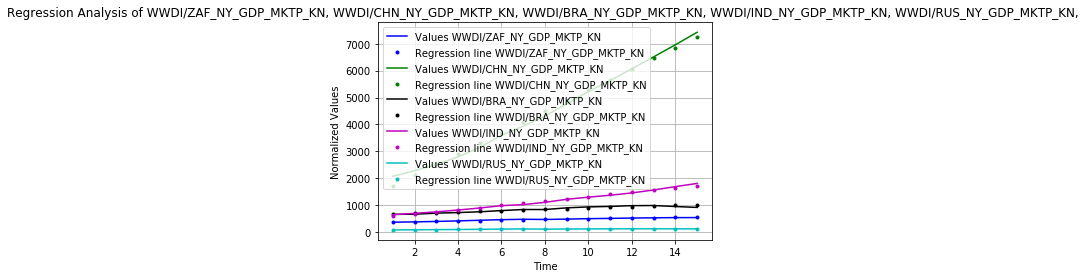

In [17]:
economics_example()

## 2. TECHNICAL ANALYSIS: TRADE ENTRY AND EXIT POSITIONS  

Regression analysis is used extensively in trading. Technical analysts use the "regression channel" to calculate entry and exit positions into a particular stock.  

Another application is pairs trading which monitors the performance of two historically correlated securities. When the correlation temporarily weakens, i.e. one stock moves up while the other moves down, the pairs trade shorts the outperforming stock and buys the under-performing one, betting that the "spread" between the two would eventually converge.  

If we wanted to compare the past 350 weeks worth of prices for Google and Yahoo with the regression channel (confidence intervals), we would use the following code,  

In [24]:
def trading_example():
    """
    This method creates a set of regression analyses based on technical trading details (price)
    """
    # b: blue, g: green, r: red, c: cyan, m: magenta, y: yellow, k: black, w: white
    statsmodels_args_trade = StatsModelsSettings(1, True)
    quandl_args_trade = quandl_settings(35, 1, "weekly")
#    quandl_args_trade = QuandlSettings(350, 4, "weekly")

    regressions_trade = [RegressionAnalysis("WIKI/YHOO", quandl_args_trade, statsmodels_args_trade, 'b'),
                         RegressionAnalysis("WIKI/GOOGL", quandl_args_trade, statsmodels_args_trade, 'b')]
    plot_regression_line(regressions_trade)

('Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Ex-Dividend', 'Split Ratio', 'Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume')
column 1
column names ('Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Ex-Dividend', 'Split Ratio', 'Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume')
col_name Open
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     178.1
Date:                Fri, 08 Dec 2017   Prob (F-statistic):           7.49e-15
Time:                        21:47:54   Log-Likelihood:                -115.95
No. Observations:                  35   AIC:                             235.9
Df Residuals:                      33   BIC:                             239.0
Df Model:                           

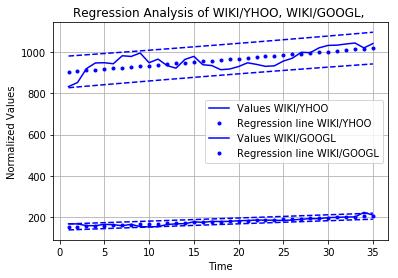

In [21]:
trading_example()

## 3. FUNDAMENTAL ANALYSIS: Italy vs France vs Germany REVENUES

Quandl.com contains historical **fundamental indicators** as well as company data for many US companies. This is the code we could need to type if we wanted to compare the revenues of Italy, France, and Germany over the past five years,

In [36]:
def investing_example():
    """
    This method creates a set of regression analyses based on fundamental trading (revenues)
    """
    # b: blue, g: green, r: red, c: cyan, m: magenta, y: yellow, k: black, w: white
    statsmodels_args_inv = StatsModelsSettings(2, False)
    quandl_args_inv = quandl_settings(5, 1, "yearly")

    regressions_inv = [RegressionAnalysis("UIFS/CG_REV_ITA", quandl_args_inv, statsmodels_args_inv, 'b'),
                       RegressionAnalysis("UIFS/CG_REV_FRA", quandl_args_inv, statsmodels_args_inv, 'g'),
                       RegressionAnalysis("UIFS/CG_REV_DEU", quandl_args_inv, statsmodels_args_inv, 'k')]
    
#     regressions_inv = [RegressionAnalysis("DMDRN/GOOG_REV_LAST", quandl_args_inv, statsmodels_args_inv, 'b'),
#                    RegressionAnalysis("DMDRN/YHOO_REV_LAST", quandl_args_inv, statsmodels_args_inv, 'g'),
#                    RegressionAnalysis("DMDRN/AAPL_REV_LAST", quandl_args_inv, statsmodels_args_inv, 'k')]

    plot_regression_line(regressions_inv)

('Date', 'TAXES (NATL CURRENCY)', 'SOCIAL CONTRIBUTIONS (NATL CURRENCY)', 'REVENUE (NATL CURRENCY)', 'OTHER REVENUE (NATL CURRENCY)')
column 1
column names ('Date', 'TAXES (NATL CURRENCY)', 'SOCIAL CONTRIBUTIONS (NATL CURRENCY)', 'REVENUE (NATL CURRENCY)', 'OTHER REVENUE (NATL CURRENCY)')
col_name TAXES (NATL CURRENCY)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     9.738
Date:                Fri, 08 Dec 2017   Prob (F-statistic):             0.0931
Time:                        21:56:35   Log-Likelihood:                -12.153
No. Observations:                   5   AIC:                             30.31
Df Residuals:                       2   BIC:                             29.13
Df Model:                           2          

/Users/cynthiacorrea/miniconda3/envs/python3/lib/python3.6/site-packages/statsmodels/stats/stattools.py:72: UserWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  "samples were given." % int(n))


('Date', 'TAXES (NATL CURRENCY)', 'SOCIAL CONTRIBUTIONS (NATL CURRENCY)', 'REVENUE (NATL CURRENCY)', 'OTHER REVENUE (NATL CURRENCY)')
column 1
column names ('Date', 'TAXES (NATL CURRENCY)', 'SOCIAL CONTRIBUTIONS (NATL CURRENCY)', 'REVENUE (NATL CURRENCY)', 'OTHER REVENUE (NATL CURRENCY)')
col_name TAXES (NATL CURRENCY)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     199.8
Date:                Fri, 08 Dec 2017   Prob (F-statistic):            0.00498
Time:                        21:56:35   Log-Likelihood:                -3.4999
No. Observations:                   5   AIC:                             13.00
Df Residuals:                       2   BIC:                             11.83
Df Model:                           2          

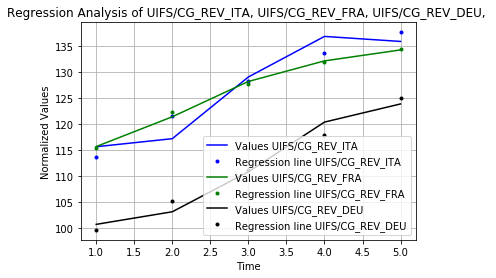

In [37]:
investing_example()

## CONCLUSION AND SOURCE CODE

In conclusion, regression analysis is a simple and yet useful tool. It can be used to help explain and compare various data-sets and is used extensively in finance, trading, risk management, and econometrics.